![Logo](LOGO_FCyT_2016.png 'FCyT-UNCA')

# <center> Universidad Nacional de Caaguazú </center>

# <center> Facultad de Ciencias y Tecnologías </center>


## <center> Cálculo de vigas continuas por el método matricial de rigidez </center>

- Diagramas de fuerza cortante y momento flector
- Desplazamiento de apoyos
- Variación de rigidez de apoyos

<p style="text-align: right;"> Prof. Fredy Gabriel Ramírez Villanueva<br>
Ingeniero Civil </p> 

## 1. Preprocesamiento

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg

### 1.1 Viga de Bernoulli

![Elemento de Viga](ElementoViga.png 'Elemento de viga')


Creamos una Clase VigaB: *"Viga de Bernoulli"* con dos grados de libertad por nudo, que se define por su módulo de elasticidad $E$, su inercia $I$ y su longitud $L$, a partir de esos datos se obtiente la matriz de rigidez del elemento:

$$ \mathbf{k} = \dfrac{EI}{L^3}
\begin{bmatrix}
12 & 6L & -12 & 6L \\
6L & 4L^2 & -6L & 2L^2 \\
-12 & -6L & 12 & -6L \\
6L & 2L^2 & -6L & 4L^2
\end{bmatrix}
$$

_

In [2]:
class VigaB:
    '''Definimos un tramo de viga.
    E: Módulo de elasticidad
    I: Inercia de la sección transversal
    L: Longitud del tramo'''
    def __init__(self, E, I, L):
        '''ATRIBUTOS:
            self.E: Módulo de elasticidad
            self.I: Inercia de la sección transversal
            self.L: Longitud del tramo
            self.k: matriz de rigidez del tramo'''
        self.E = E
        self.I = I
        self.L = L
        
        #Matriz de rigidez del elemento
        self.k = E * I / L**3 * np.array([
                [12., 6*L, -12, 6*L],
                [6*L, 4*L**2, -6*L, 2*L**2],
                [-12, -6*L, 12, -6*L],
                [6*L, 2*L**2, -6*L, 4*L**2]
            ])

### 1.2 Cargas

Consideramos 3 tipos de cargas, a saber:

- Tipo 0: Carga puntual
- Tipo 1: Carga distribuida (total o parcialmente en el tramo de viga)
- Tipo 3: Momento concentrado

In [3]:
class Carga:
    '''Clase carga'''
    def __init__(self, tipo):
        '''
        tipo = 0: Carga puntual
        tipo = 1: Carga distribuida
        tipo = 2: Momento cocentrado
        '''
        self.tipo = tipo
    
    def Tipo(self):
        if self.tipo == 0:
            print("Carga puntual")
        elif self.tipo == 1:
            print('Carga distribuida')
        elif self.tipo == 2:
            print('Momento concentrado')
        else:
            print('No definido')

### 1.2.1 Carga puntual

![Carga puntual](CargaPuntual.png 'Carga puntual')

Se define con su valor $P$ y su ubicación $a$ respecto al extremo izquierdo del tramo. Con el método Qf se obtiene las reacciones nodales equivalentes:
$$ Q_f = \dfrac{P}{L^2} \begin{bmatrix}
\dfrac{b^2}{L} (3a + b) \\ ab^2 \\ \dfrac{a^2}{L} (a + 3b) \\ -a^2b
\end{bmatrix}
$$

En este lugar también calculamos el aporte de esta carga a la fuerza cortante y al momento flector. Para considerar el aporte a la fuerza cortante, ya que aún desconocemos las reacciones en los apoyos, en el método FQ, consideramos una viga sin apoyo, es decir con reacciones iguales a cero, así la fuerza cortante $Q(x)$ es:
$$
Q(x) = \begin{cases}
-P & \mbox{si } a < x \le L \\
0 & \mbox{de otra manera}
\end{cases}
$$

En el caso del momento flector, al desconocer aún los valores en los extremos, en el método MF, suponemos una viga simplemente apoyada (momentos flectores iguales a cero en los extremos), entonces:
$$
M(x) = \begin{cases}
\left( 1 - \dfrac{a}{L} \right) Px & \mbox{si } 0 \le x < a \\
a P (1-\dfrac{x}{L}) & \mbox{si } a \le x \le L \\
0 & \mbox{de otra manera}
\end{cases}
$$
_

In [4]:
class CargaPuntual(Carga):
    '''Clase carga puntual'''
    def __init__(self, P=0, a=0):
        '''Carga puntual P.
        P: valor de la carga. Positivo hacia abajo.
        a: posicion de la carga respecto al extremo izquierdo del tramo.'''
        Carga.__init__(self, 0)
        self.P = P
        self.a = a
    
    def __str__(self):
        return 'Carga puntual\n   Valor= ' + str(self.P) + 'N' \
    + '\n   Posición, x= ' + str(self.a) + 'm'
    
    #Reacciones nodales equivalentes
    def Qf(self, L):
        '''Reacciones nodales equivalentes para una carga puntual.
        L: Longitud de la viga'''
        a = self.a
        b = L - a
        return self.P / L**2 * np.array([
                [b**2 / L * (3*a + b)],
                [a * b**2],
                [a**2 / L * (a + 3*b)],
                [-a**2 * b]
            ])
    
    #Fuerza cortante en una sección (viga sin apoyos)
    def FQ(self, x, L):
        '''Aporte a la fuerza cortante en una sección debido a una carga puntual,
        x: posición de la sección considerada respecto al extremo izquierdo
        L: longitud del tramo'''
        if self.a < x <= L:
            return -self.P
        else:
            return 0
         
    #Momento flector en una sección (viga simplemente apoyada)
    def MF(self, x, L):
        '''Aporte al Momento flector en una sección debido a una carga puntual,
        x: posición de la sección considerada respecto al extremo izquierdo
        L: longitud del tramo'''
        if 0 <= x < self.a:
            return (1 - self.a/L) * self.P * x
        elif x <= L:
            return self.a * self.P * (1 - x/L)
        else:
            return 0

In [5]:
P1 = CargaPuntual(10000, 2)

In [6]:
print(P1)

Carga puntual
   Valor= 10000N
   Posición, x= 2m


In [7]:
P1.a

2

### 1.2.2 Carga uniformemente distribuida

![Carga distribuida](CargaDist.png 'Carga distribuida')

Se define con su valor $q$, la coordenada $a$ de su inicio,  respecto al extremo izquierdo del tramo, y su longitud de distribución $l$. Con el método Qf se obtiene las reacciones nodales equivalentes:
$$ Q_f = \dfrac{1}{2} qL \begin{bmatrix}
1 - \dfrac{a}{L^4} (3L^3 - 2a^2L + a^3) - \dfrac{b^3}{L^4} (2L - b) \\
\dfrac{L}{6} \left( 1 - \dfrac{a^2}{L^4} (6L^2-8aL+3a^2)-\dfrac{b^3}{L^4}(4L-3b) \right) \\
1 - \dfrac{a^3}{L^4} (2L - a) - \dfrac{b}{L^4} (2L^3 - 2b^2L + a^3) \\
-\dfrac{L}{6} \left( 1 - \dfrac{a^3}{L^4}(4L-3a) -\dfrac{b^2}{L^4}(6L^2-8bL+3b^2) \right)
\end{bmatrix}
$$

Analogamente al caso anterior, con el método FQ, consideramos una viga sin apoyo, es decir con reacciones iguales a cero, así la fuerza cortante $Q(x)$ es:
$$
Q(x) = \begin{cases}
-q(x-a) & \mbox{si } a \le x < a+l \\
-ql & \mbox{si } a+l \le x \le L \\
0 & \mbox{de otra manera}
\end{cases}
$$

De la misma forma, en el método MF, suponemos una viga simplemente apoyada (momentos flectores iguales a cero en los extremos), entonces, haciendo:

$$V_1 = \dfrac{ql}{L} \left( L - a - \dfrac{l}{2} \right); \qquad V_2 = ql - V_1$$

$$
M(x) = \begin{cases}
V_1 x & \mbox{si } 0 \le x < a \\
V_1 x - \dfrac{1}{2}q(x-a) & \mbox{si } a \le x \le a+l \\
V_2(L-x) & \mbox{si } a+l < x \le L \\
0 & \mbox{de otra manera}
\end{cases}
$$
_

In [8]:
class CargaDistribuida(Carga):
    '''Clase carga distribuida'''
    def __init__(self, q=0, a=0, l=0):
        '''Carga puntual P.
        P: valor de la carga. Positivo hacia abajo.
        a: distancia entre el extremo izquierdo del tramo y el inicio de la carga.
        l: longitud de la carga distribuida'''
        Carga.__init__(self, 1)
        self.q = q
        self.a = a
        self.l = l
    
    def __str__(self):
        return 'Carga distribuida\n   Valor= ' + str(self.q) + 'N/m'\
    ', ' + '\n   Inicio= ' + str(self.a) + 'm' + '\n   Longitud= ' + str(self.l) + 'm'
    
    def Qf(self, L):
        '''Reacciones nodales equivalentes para una carga
        unifomemente distribuida.
        L: longitud de la viga'''
        q = self.q
        a = self.a
        b = L - self.a - self.l
        return q * L / 2 * np.array([
                [1 - a/L**4*(2*L**3 - 2*a**2*L + a**3) - b**3/L**4*(2*L - b)],
                [L/6*(1 - a**2/L**4*(6*L**2 - 8*a*L + 3*a**2) - b**3/L**4*(4*L - 3*b))],
                [1 - a**3/L**4*(2*L - a) - b/L**4*(2*L**3 - 2*b**2*L + a**3)],
                [-L/6*(1 - a**3/L**4*(4*L - 3*a) - b**2/L**4*(6*L**2 - 8*b*L + 3*b**2))]
            ])
            
    #Fuerza cortante en una sección (viga sin apoyos)
    def FQ(self, x, L):
        '''Aporte a la fuerza cortante en una sección debido a la carga distribuida.
        x: posición de la sección considerada respecto al extremo izquierdo
        L: Longitud del tramo'''
        if self.a <= x < self.a + self.l:
            return -self.q * (x - self.a)
        elif x <= L:
            return -self.q * self.l
        else:
            return 0
    
    #Momento flector en una sección (viga simplemente apoyada)
    def MF(self, x, L):
        '''Aporte al momento flector en una sección debido a la carga distribuida.
        x: posición de la sección considerada respecto al extremo izquierdo
        L: Longitud del tramo'''
        V1 = self.q*self.l/L*(L - self.a - self.l/2)
        V2 = self.q*self.l - V1
        if 0 <= x < self.a:
            return V1 * x
        elif x <= self.a + self.l:
            return V1*x - 0.5*self.q*(x-self.a)**2
        elif x <= L:
            return V2 * (L - x)
        else:
            return 0

In [9]:
q1 = CargaDistribuida(5000, 1, 3)

In [10]:
print(q1)

Carga distribuida
   Valor= 5000N/m, 
   Inicio= 1m
   Longitud= 3m


In [11]:
q1.Qf(6)

array([[  9201.38888889],
       [ 11354.16666667],
       [  5960.64814815],
       [ -8645.83333333]])

In [12]:
q1.MF(2, 6)

15000.0

### 1.2.3 Momento concentrado

![Momento concentrado](MomentoConc.png 'Momento concentrado')

Se define con su valor $M$ y su ubicación $a$ respecto al extremo izquierdo del tramo. Con el método Qf se obtiene las reacciones nodales equivalentes:
$$ Q_f = \dfrac{M}{L^2} \begin{bmatrix}
-\dfrac{6ab}{L} \\ b(b-2a) \\ \dfrac{6ab}{L} \\ a(a-2b)
\end{bmatrix}
$$

En el método FQ, consideramos una viga sin apoyo, es decir con reacciones iguales a cero, así la fuerza cortante $Q(x)$ es:
$$
Q(x) = 0 \mbox{ en } -\infty < x < \infty \\
$$
En el método MF, suponemos una viga simplemente apoyada (momentos flectores iguales a cero en los extremos), entonces:
$$
M(x) = \begin{cases}
\dfrac{x}{L} M & \mbox{si } 0 \le x < a \\
(\dfrac{x}{L}-1) M & \mbox{si } a \le x \le L \\
0 & \mbox{de otra manera}
\end{cases}
$$
_

In [13]:
class MomentoConcentrado(Carga):
    '''Clase momento concentrado'''
    def __init__(self, M=0, a=0):
        '''Momento concentrado M.
        M: valor del momento concentrado. Antihorario positivo
        a: posición del momento respecto al extremo izquierdo del tramo'''
        Carga.__init__(self, 2)
        self.M = M
        self.a = a
    
    def __str__(self):
        return 'Momento concentrado\n   Valor= ' + str(self.M) + 'Nm' \
    + '\n   Posición, x= ' + str(self.a) + 'm'
    
    def Qf(self, L):
        '''Reacciones nodales equivalentes para un momento concetrado.
        L: longitud de la viga'''
        a = self.a
        b = L - a
        return self.M / L**2 * np.array([
                [-6*a*b/L],
                [b*(b - 2*a)],
                [6*a*b/L],
                [a*(a - 2*b)]
            ])
    
    #Fuerza cortante en una sección (viga sin apoyos)
    def FQ(self, x, L):
        '''Aporte a la fuerza cortante en una sección debido a la carga distribuida.
        x: posición de la sección considerada respecto al extremo izquierdo'''
        return 0
    
    #Momento flector en una sección (viga simplemente apoyada)
    def MF(self, x, L):
        '''Aporte al momento flector en una sección debido a un momento concetrado,
        Estos valores corresponden al de una viga simplemente apoyada.
        x: posición de la sección considerada respecto al extremo izquierdo
        L: Longitud del tramo'''
        if 0 <= x < self.a:
            return self.M / L * x
        elif self.a < x <= L:
            return self.M * (x/L - 1)
        else:
            return 0

In [14]:
M1 = MomentoConcentrado(600, 3)

In [15]:
print(M1)

Momento concentrado
   Valor= 600Nm
   Posición, x= 3m


In [16]:
M1.MF(2, 8)

150.0

## 2. Datos de la viga continua

### 2.1 Ejemplo

![Viga de ejemplo](VigaEjemplo.png "Viga de ejemplo")

$E = 20 GPa$

$I = 3,6 \times 10^{-3} m^4$

In [17]:
#Definimos los tramos de la viga continua en una lista
# VigaB(Elasticidad, Inercia, Longitud) por cada tramo
E = 20e9 #Pa
I = 3.6e-3 #m4
Tramo = [VigaB(E, I, 6), VigaB(E, I, 8)]

In [18]:
#Cargas en cada tramo
#q = CargaDistribuida(valor, inicio, longitud), el inicio es respecto al nudo izq. del tramo
#P = CargaPuntual(valor, posición), la posición es respecto al nudo izq. del tramo
#M = MomentoConcentrado(valor, posición), la posición es respecto al nudo izq. del tramo
q = CargaDistribuida(8000, 0, 6)
p = CargaPuntual(12000, 4)
cargas = [
    [q], #carga en tramo 1
    [p] #carga en tramo 2
]

### 2.2 Desplazamiento de apoyos
Los apoyos pueden sufrir desplazamientos $a_i \ (i=1, \dots, r)$ siendo $r$ el número de reacciones.

In [19]:
#Desplazamiento de apoyos (vector columna r x 1)
a = np.array([
        [0],
        [0],
        [0],
        [0]
    ])

### 2.3 Tipo de apoyo en los extremos

![Tipos de apoyos](Apoyos3D.png 'Tipos de apoyo')

In [20]:
#Tipo de apoyos izquierdo y derecho
# apoyo = 0: Empotramiento
# apoyo = 1: Permite desplazamiento vertical
# apoyo = 2: Permite giro pero no desplazamiento
# apoyo = 3: Voladizo
apoyoIzq = 2
apoyoDer = 0

## 3. Procesamiento

Debemos resolver un sistema matricial del tipo $$ \mathbf{Q} = \mathbf{K u} $$
Por lo que ensamblamos la matriz de rigidez global de la estructura por el método de rigidez directa. Si $j$ es el número de nudos, la matriz de rigidez será de orden $2j \times 2j$. Notemos también que, en el caso de vigas continuas, el número de nodos $j$ es igual al número de barras $b$ más $1$, es decir $j = b + 1$
La ecuación a resolver es:
$$ \mathbf{Q}_{(2j \times 1)} = \mathbf{K}_{(2j \times 2j)} \ \mathbf{u}_{(2j \times 1)} $$

In [21]:
#Número de tramos o barras
b = len(Tramo)

#Número de nudos
nudos = b + 1

#Longitud total de la viga
Ltotal = 0
for i in range(b):
    Ltotal += Tramo[i].L

### 3.1 Matriz de rigidez

El ensamble de la matriz de rigidez global se realiza por el método de rigidez directa.

In [22]:
#Ensamble de la matriz de rigidez global
K = np.zeros((2*nudos, 2*nudos))
for i in range(b):
    K[2*i:2*i+4, 2*i:2*i+4] += Tramo[i].k

### 3.2 Método de penalización

$\mathbf{K}$ es singular. Para poder invertir la matriz suponemos que los apoyos son resortes con una gran rigidez $C \approx \max(K_{ij}) \times 10^4$

![Hipótesis del método de penalización](ApoyoResorte.png 'Hipótesis del método de penalización')

Agregamos el valor $C$ a los elementos diagonales de la matriz de rigidez correspondientes a los grados de libertad restringidos.
$$ \mathbf{S} = \begin{bmatrix}
K_{11} + C & K_{12} & K_{12} & \cdots \\
K_{21} & K_{22} & K_{21} & \cdots \\
K_{31} & K_{32} & K_{33} + C & \cdots \\
\vdots & \vdots & \vdots & \cdots
\end{bmatrix}_{\ 2j \times 2j}
$$
_

In [23]:
#Los grados de libertad restringidos son:
gdlRest = []

#En general
for i in range(b):
    gdlRest.append(2*i)
    
#Extremo izquierdo
if apoyoIzq == 0: #empotramiento
    gdlRest.insert(1, 1)
elif apoyoIzq == 1: #restricción al giro
    gdlRest[0] = 1
elif apoyoIzq == 3: #voladizo
    del gdlRest[0]
else: #apoyo de segundo grado
    pass

#Extremo derecho
if apoyoDer == 0: #empotramiento
    gdlRest.append(2*b)
    gdlRest.append(2*b + 1)
elif apoyoDer == 1: #restricción al giro
    gdlRest.append(2*b + 1)
elif apoyoDer == 2: #apoyo de segundo género
    gdlRest.append(2*b)
else: #voladizo
    pass

In [24]:
#Número de reacciones (grados de libertad restringidos)
r = len(gdlRest)
r

4

In [25]:
gdlRest

[0, 2, 4, 5]

In [26]:
#Rigidez C (vector columna r x 1)
C = np.amax(K) * 1e4 * np.array([
        [1],
        [1],
        [1],
        [0.0001]
    ])
C

array([[  8.40000000e+11],
       [  8.40000000e+11],
       [  8.40000000e+11],
       [  8.40000000e+07]])

In [27]:
#Modificación de la matriz de rigidez por el enfoque de penalización
S = K
cont = 0 #contador para identificar los elementos de C
for i in gdlRest:
    S[i,i] += C[cont]
    cont += 1

### 3.3 Vector de cargas nodales $Q_f$

In [28]:
#Reacciones nodales equivalentes en cada tramo
QF = [0]*b #para guardar los vectores de reacciones nodales equivalentes de cada tramo

for i in range(b): #recorre todos los tramos
    for j in range(len(cargas[i])): #considera todas las cargas de cada tramo
        QF[i] += cargas[i][j].Qf(Tramo[i].L)

In [29]:
QF[0]

array([[ 24000.],
       [ 24000.],
       [ 24000.],
       [-24000.]])

In [30]:
QF[1]

array([[  6000.],
       [ 12000.],
       [  6000.],
       [-12000.]])

In [31]:
#Ensamble del vector Qf para todos los gdl, incluidos los restringidos
Qf = np.zeros((2*nudos,1))
for i in range(b):
    Qf[2*i:2*i+4,:] += QF[i]

In [32]:
Qf

array([[ 24000.],
       [ 24000.],
       [ 30000.],
       [-12000.],
       [  6000.],
       [-12000.]])

Agregamos el valor $C_i a_i \ (i=1,\dots,r)$ a los elementos del vector de cargas correspondientes a los gdl restringidos.
$$ \mathbf{P} = \begin{bmatrix}
F_{1} + C_1 a_1 \\
F_{2} \\
F_{3} + C_2 a_2 \\
\vdots
\end{bmatrix}_{\ 2j \times 1}
$$
_

In [33]:
#Modificación del vector de cargas por el enfoque de penalización
P = Qf
for i in range(r):
    P[gdlRest[i],0] = Qf[gdlRest[i],0] + C[i,0] * a[i,0]

In [34]:
P

array([[ 24000.],
       [ 24000.],
       [ 30000.],
       [-12000.],
       [  6000.],
       [-12000.]])

## 4. Resultados

### 4.1 Desplazamientos nodales

$$ \mathbf{d} = \mathbf{S}^{-1} \ \mathbf{P} 
$$

In [35]:
#Desplazamientos nodales
d = -np.linalg.inv(S) @ P
d

array([[ -2.37167941e-08],
       [ -6.60178893e-04],
       [ -4.35605206e-08],
       [  3.20347865e-04],
       [ -4.15125674e-09],
       [  5.19500370e-05]])

$ \mathbf{d} \rightarrow \mathbf{u} $

![Elemento de viga](ElementoViga.png 'Elemento de viga')

In [36]:
#Desplazamientos nodales por tramo
u = []
for i in range(b):
    u.append(d[2*i:2*i+4,:])

In [37]:
u[1]*1000 #mm

array([[ -4.35605206e-05],
       [  3.20347865e-01],
       [ -4.15125674e-06],
       [  5.19500370e-02]])

### 4.2 Fuerzas en cada tramo

$$
\mathbf{F}^{(i)} = \mathbf{k}^{(i)} \mathbf{u}^{(i)} + \mathbf{Q}^{(i)}_{f} \qquad i = 1, \dots, b
$$

In [38]:
#Fuerzas en cada tramo
F = []
for i in range(b):
    F.append(Tramo[i].k @ u[i] + QF[i])

In [39]:
F[1]/1000 #kN

array([[  8.51294434],
       [ 24.4673578 ],
       [  3.48705566],
       [ -4.36380311]])

### 4.3 Reacciones

$$ R_i = -C_i ( \delta_i - a_i)
\qquad i = 1, \dots, r$$

$\delta_i$: deformaciones de los "resortes"

In [40]:
#Reacciones
δ = d[gdlRest]
R = -C * (δ - a)

In [41]:
R/1000 #kN

array([[ 19.92210703],
       [ 36.5908373 ],
       [  3.48705566],
       [ -4.36380311]])

### 4.4 Valores de fuerza cortante

In [42]:
#Número de secciones a tomar para los gráficos en cada tramo
numS = 1000
Xt = [] #para guardar las x de cada tramo
for i in range(b):
    Xt.append(np.linspace(0, Tramo[i].L, numS)) #Ubicación de las secciones

In [43]:
Cortantes = []
for i in range(b): #para cada tramo
    
    #Cortantes como vigas sin apoyo
    Q0 = np.zeros(numS)
    for j in range(len(cargas[i])): #considera todas las cargas de cada tramo
        m = 0 #para enumerar las secciones
        for x in Xt[i]: #recorre las secciones
            Q0[m] += cargas[i][j].FQ(x, Tramo[i].L)
            m += 1
    
    #Cortantes en el extremo izquierdo, obtenido del cálculo
    Q1 = F[i][0]
    
    #Cortante total
    Cortantes.append(Q0 + Q1)

In [44]:
#Máximos y mínimos valores de fuerza cortante (en cada tramo)
maxCortante = [] #Cortantes máximos por cada tramo
minCortante = [] #Cortantes mínimos por cada tramo
XmaxQ= [] #ubicaciones de los máximos en cada tramo
XminQ = [] #ubicaciones de los mínimos en cada tramo
for i in range(b):
    maxQ = max(Cortantes[i]) #Máximo cortante
    minQ = min(Cortantes[i]) #Mínimo cortante
    maxCortante.append(maxQ)
    minCortante.append(minQ)
    indMaxQ = np.where(Cortantes[i] == maxQ )[0][0] #ubicación del máximo cortante
    indMinQ = np.where(Cortantes[i] == minQ )[0][0] #ubicación del mínimo cortante
    XmaxQ.append(Xt[i][indMaxQ])
    XminQ.append(Xt[i][indMinQ])

### 4.4 Valores de momento flector

In [45]:
Flectores = []
for i in range(b): #para cada tramo
    
    #Momentos como tramos simplemente apoyados
    M0 = np.zeros(numS)
    for j in range(len(cargas[i])): #considera todas las cargas de cada tramo
        m = 0 #para enumerar las secciones
        for x in Xt[i]: #recorre las secciones
            M0[m] += cargas[i][j].MF(x, Tramo[i].L)
            m += 1
    
    #Momentos debidos a los empotramientos o a la continuidad de la viga
    M1 = -F[i][1] + (F[i][3] + F[i][1]) / Tramo[i].L * Xt[i]
    
    #Momento total
    Flectores.append(M0 + M1)

In [46]:
#Máximos y mínimos valores de momento flector (en cada tramo)
maxFlector = [] #Flector máximo en cada tramo
minFlector = [] #Flector mínimo en cada tramo
XmaxF= [] #ubicaciones de los flectores máximos por tramo
XminF = [] #ubicaciones de los mínimos flectores por tramo
for i in range(b):
    maxF = max(Flectores[i]) #Máximo flector
    minF = min(Flectores[i]) #Mínimo flector
    maxFlector.append(maxF)
    minFlector.append(minF)
    indMaxF = np.where(Flectores[i] == maxF )[0][0] #ubicación del máximo flector
    indMinF = np.where(Flectores[i] == minF )[0][0] #ubicación del mínimo flector
    XmaxF.append(Xt[i][indMaxF])
    XminF.append(Xt[i][indMinF])

### 4.5 Diagrama de fuerza cortante

In [47]:
#Valores de x para los gráficos
X = []
Lacum = 0
for i in range(b):
    if i > 0:
        Lacum += Tramo[i-1].L
    Xprov = Xt[i] + Lacum
    Xlist = Xprov.tolist()
    X += Xlist

In [48]:
#Valores de la fuerza cortante para los gráficos
DFQ = []
for i in range(b):
    #Valores para el DFQ tipo lista
    Corta = (Cortantes[i]/1000).tolist() #Pasamos a kN y convertimos en lista
    DFQ += Corta

<IPython.core.display.Javascript object>


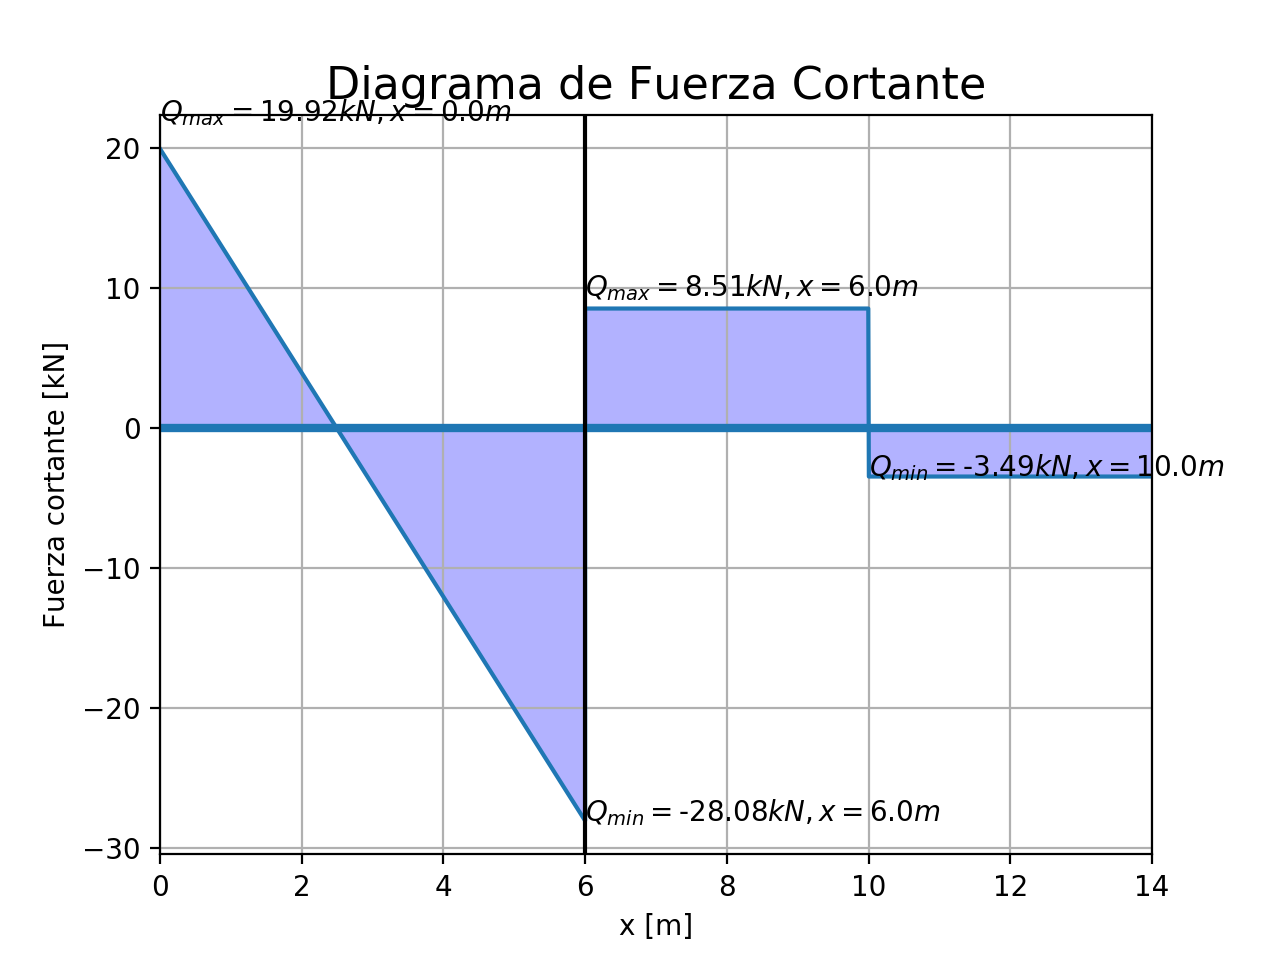

In [49]:
#Graf. principal de fuerza cortante
plt.figure(1)
plt.plot(X, DFQ)
plt.title('Diagrama de Fuerza Cortante', fontsize = 16)
plt.xlabel('x [m]')
plt.ylabel('Fuerza cortante [kN]')
plt.axhline(linewidth = 3)
plt.xlim(0, Ltotal)
plt.grid()

#Textos para valores máximos y mínimos
def colocarTextosQ():
    LacumQ = 0
    for i in range(b):
        if i > 0:
            LacumQ += Tramo[i-1].L
        ubicMax = LacumQ + XmaxQ[i]
        ubicMin = LacumQ + XminQ[i]
        if ubicMax == Ltotal:
            ubicMax = Ltotal - Tramo[i].L/2
        if ubicMin == Ltotal:
            ubicMin = Ltotal - Tramo[i].L/2
        plt.text(ubicMax, maxCortante[i]/1000*1.1, '$Q_{max} = $' + \
                 str(round(maxCortante[i]/1000,2)) + '$kN, x= $' + str(round(ubicMax,2)) \
                 + '$m$')
        plt.text(ubicMin, minCortante[i]/1000*1, '$Q_{min} = $' + \
                 str(round(minCortante[i]/1000,2)) + '$kN, x= $' + str(round(ubicMin,2)) \
                 + '$m$')

colocarTextosQ()
        
#Para sombrear el graf.
Xgraf = [0] + X
Xgraf.append(Ltotal)

DFQgraf = [0] + DFQ
DFQgraf.append(0)

plt.fill(Xgraf, DFQgraf, 'b', alpha=0.3)

#Divisores de tramos
vertical = 0
for i in range(b - 1):
    vertical += Tramo[i].L
    plt.axvline(vertical, color='black')

plt.show()

### 4.4 Diagrama de momento flector

In [50]:
#Valores del momento flector para los gráficos
DMF = []
for i in range(b):
    #Valores para el DMF tipo lista
    Flex = (Flectores[i]/1000).tolist() #Pasamos a kNm y convertimos en lista
    DMF += Flex

<IPython.core.display.Javascript object>


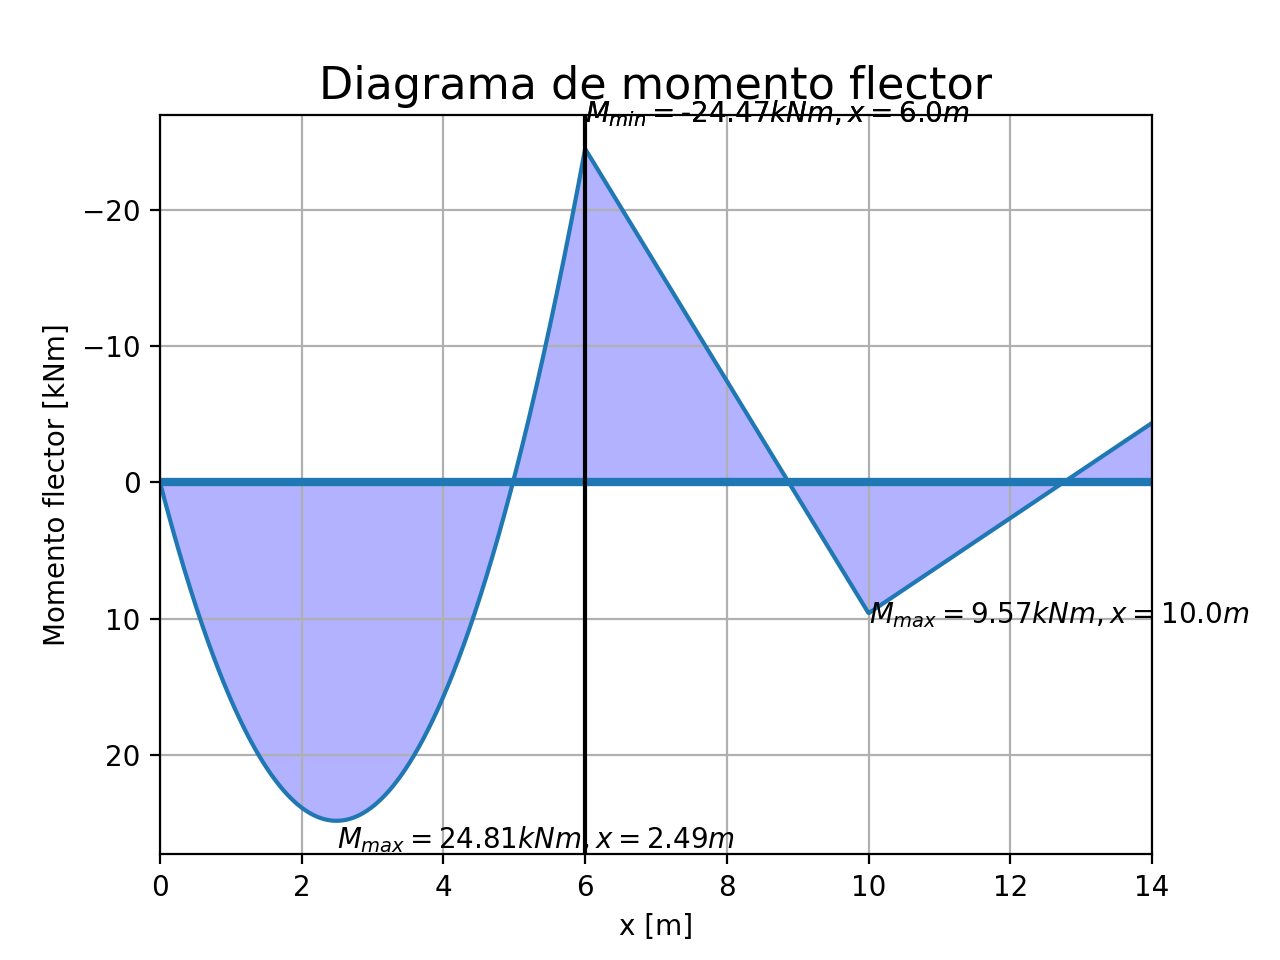

In [51]:
#Graf. principal
plt.figure(2)
plt.plot(X, DMF)
plt.title('Diagrama de momento flector', fontsize = 16)
plt.xlabel('x [m]')
plt.ylabel('Momento flector [kNm]')
plt.gca().invert_yaxis() #invierte el eje y
plt.axhline(linewidth = 3)
plt.xlim(0, Ltotal)
plt.grid()

#Función para colocar Textos de valores máximos y mínimos en flexión
def colocarTextosF():
    LacumM = 0
    for i in range(b):
        if i > 0:
            LacumM += Tramo[i-1].L
        ubicMax = LacumM + XmaxF[i]
        ubicMin = LacumM + XminF[i]
        if ubicMax == Ltotal:
            ubicMax = Ltotal - Tramo[i].L/2
        if ubicMin == Ltotal:
            ubicMin = Ltotal - Tramo[i].L/2
        plt.text(ubicMax, maxFlector[i]*0.00108, '$M_{max} = $' + \
                 str(round(maxFlector[i]/1000,2)) + '$kNm, x= $' + str(round(ubicMax,2)) \
                 + '$m$')
        plt.text(ubicMin, minFlector[i]*0.00108, '$M_{min} = $' + \
                 str(round(minFlector[i]/1000,2)) + '$kNm, x= $' + str(round(ubicMin,2)) \
                 + '$m$')

colocarTextosF()
        
#Para sombrear el graf.
Xgraf = [0] + X
Xgraf.append(Ltotal)

DMFgraf = [0] + DMF
DMFgraf.append(0)

plt.fill(Xgraf, DMFgraf, 'b', alpha=0.3)

#Divisores de tramos
vertical = 0
for i in range(b - 1):
    vertical += Tramo[i].L
    plt.axvline(vertical, color='black')

plt.show()